## Summary: StackOverflow Survey Analysis

Given that the classification model using StackOverflow tags had poor F1-scores (learning just 7% on average better than the benchmark model), I decided to use a different dataset generated from StackOverflow's annual user survey. The objective was the same: to use market signals from StackOverflow data to predict which databases are most desirable and likely to be chosen.

Both datasets have a similar selection bias, that they're dependent on the complextion of the overall StackOverflow community. Alhtough I had realized this issue while analyzing the tags dataset, it is much more difficult to understand community complextion. I tried to combine the Users dataset, which includes account created, geography, and other descriptive statistics, but it did not provide enough information to explain tag counts or combinations of tags. 

However, the StackOverflow annual user survey provides a much clearer signal of community complextion, though survey/selection bias also needs to be considered. As a result, the predictability metrics are much better, and exploratory data analysis was much easier visualize and explain.

The primary insight was that the combination of current platform and desired platform choices determined the database selection. In fact, the relationship is so strong between Microsoft Azure and Microsoft SQL Server, that almost 100% of the time developers who use Microsoft Azure also desire SQL Server.

There are some caveats and important weaknesses of this insight:

  1) It is impossible to predict with 100% certainty that SQL Server will be chosen when Azure is chosen, because: 
    
    a) other cloud providers offer SQL Server, and 
    b) Azure offers more than just SQL Server as a database service.
          
  2) The explanatory power of platform choices drops dramatically for popular platforms, such as Amazon Web Services and Google Compute Platform, because: 

    a) developer types and reasons for using a platform vary much more; and 
    b) some databases are featured less prominently on other cloud platforms (Microsoft markets SQL Server much more than AWS does).
   
   
A full briefing of the analysis is below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from scipy import stats

# pipelines
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

### Overview of StackOverflow Survey Dataset

StackOverflow has been conducting an annual user survey since 2012, providing a longitudinal perspective of technology adoption, developer behaviors, wages, and hot topics impacting the developer community. 

The survey is extensive with 128 questions, some of which have as many as 16 answer choices. The survey has also steadily in popularity from just under 8000 respondents in 2012 to over 64,000 from 190 countries in 2020. As a result, it has become the largest and most important survey of the technical community in the world. Technology companies, such as Microsoft and Amazon, use StackOverflow's survey as a key source of market data about this population.

However, this dataset does have its flaws. StackOverflow promotes its survey to its base and does not provide incentives to start and finish the survey. As a result, there is a certain amount of survey bias that may not represent the overall developer population. 

Although there are multiple years of data available to the public, only the latest year's data are necessary to build predictors for desired databases. The EDA of the 2020 dataset helped to determine which features would be most relevant, followed by a further pruning of features to ensure that the model was generally applicable to the rest of the technical community. Biases and model skewing are considered along the way.

In [2]:
df_20 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2020/survey_results_public.csv')
# df_19 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2019/survey_results_public.csv')
# df_18 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2018/survey_results_public.csv')
def prettify(ax):
  ax.grid(False)
  ax.set_frame_on(False)
  ax.tick_params(top=False, bottom=False, left=False, right=False, labelbottom=False)

In [56]:
list(df_20)

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

In [75]:
#choosing relevant features from 2020 survey
relevant_data_20 = df_20[['Respondent', 
                          'Country',  
                          'PurchaseWhat',
                          'UndergradMajor',
                          'Hobbyist', 
                          'Employment',
                          'DevType', 
                          'DatabaseDesireNextYear', 
                          'DatabaseWorkedWith', 
                          'PlatformDesireNextYear', 
                          'PlatformWorkedWith']]
relevant_data_20.head(10)

,Respondent,Country,PurchaseWhat,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
0,1,Germany,NaN,"Computer science, computer engineering, or sof...",Yes,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...",Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows
1,2,United Kingdom,I have little or no influence,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,NaN,iOS;Kubernetes;Linux;MacOS,iOS
2,3,Russian Federation,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,I have a great deal of influence,"Computer science, computer engineering, or sof...",Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,United States,NaN,"Computer science, computer engineering, or sof...",Yes,Employed full-time,NaN,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows
5,6,Germany,I have some influence,NaN,No,Employed full-time,"Designer;Developer, front-end;Developer, mobile",NaN,NaN,Android,Android;Docker;WordPress
6,7,India,NaN,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",NaN,NaN,NaN,NaN
7,8,United States,I have some influence,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end;Developer, desktop or ente...",MongoDB,MariaDB;MySQL;Redis,iOS;Slack Apps and Integrations,Docker
8,9,Tunisia,NaN,"Computer science, computer engineering, or sof...",No,"Independent contractor, freelancer, or self-em...","Developer, full-stack",NaN,NaN,NaN,WordPress
9,10,United Kingdom,I have a great deal of influence,Mathematics or statistics,Yes,Employed full-time,"Database administrator;Developer, full-stack;D...",Microsoft SQL Server,Microsoft SQL Server,Android;Linux;Raspberry Pi;Windows,Android;Linux;Raspberry Pi;Windows


### Data Cleaning and EDA

Survey data can be very messy, especially open-ended questions. Fortunately, most of the columns were relatively clean, but some needed to be split, hot-encoded, and transformed for the model. Each step has a more detailed explanation below.

In [77]:
relevant_data_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              64461 non-null  int64 
 1   Country                 64072 non-null  object
 2   PurchaseWhat            39364 non-null  object
 3   UndergradMajor          50995 non-null  object
 4   Hobbyist                64416 non-null  object
 5   Employment              63854 non-null  object
 6   DevType                 49370 non-null  object
 7   DatabaseDesireNextYear  44070 non-null  object
 8   DatabaseWorkedWith      49537 non-null  object
 9   PlatformDesireNextYear  50605 non-null  object
 10  PlatformWorkedWith      53843 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.4+ MB


### Some insights about country of origin

Country of origin could provide interesting insights about respondents and their answer choices. Considerations include: a) access to technology and education, b) spoken language, c) affordability, and d) representation of overall population (or trying to draw comparisons between the StackOverflow community and the global technical community).

One of the first insights provided by doing a simple count was the seemingly over representation of US and India populations. The StackOverflow community is also highly skewed towards English speaking countries, given that StackOverflow questions and answers are not translated. Therefore, this model may not be a good proxy for the overall technical community, suggesting that it could predict desired databases for the StackOverflow community, but may not be as predictive in 'real world' scenarios.

Respondents from the US, India, UK, Germany and Canada constitute almost 50% of all respondents. This makeup would suggest a good predictor for desired databases, given that the weight for each would be significant. However, respondents from the other 185 countries would have much less significance or 'explainability'. Pruning the decision tree became much easier with this implication in mind.

<AxesSubplot:title={'center':'Number of Respondents from Countries'}>

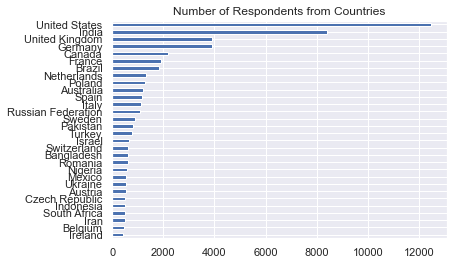

In [57]:
#counting number of respondents per country
country_20 = relevant_data_20['Country'].value_counts()
top_country_20 = country_20.head(30).sort_values(ascending = True)
top_country_20.plot(kind = 'barh', title = 'Number of Respondents from Countries')

### Respondent types

Respondents could choose multiple answer choices, making it difficult to ascertain their primary job function. For instance, many of the respondents who selected "Developer, back-end" and "Developer, front-end", would have also chosen "Developer, full-stack". Therefore, there are probably many more respondent types who would self-identify as "Developer, full-stack" than what is represented in the data. 

In order to mitigate this selection bias, the column was split into columns for each answer choice and summed to show which answer choice was chosen most frequently.

<AxesSubplot:title={'center':'Number of Developers per Devtype'}>

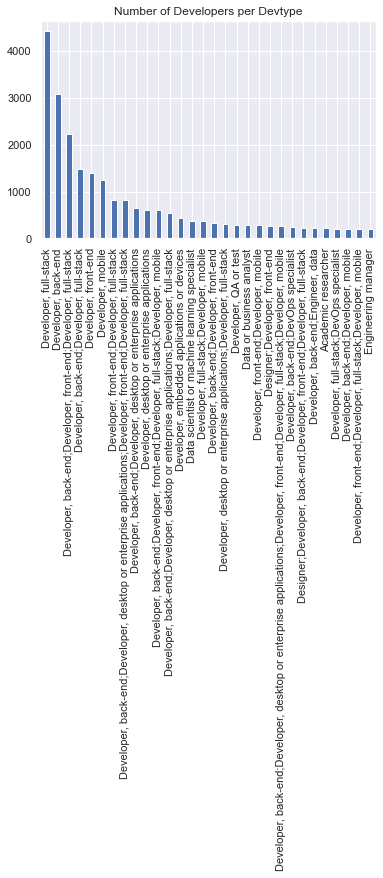

In [59]:
devtype_20 = relevant_data_20['DevType'].value_counts()
devtype_20 = devtype_20.head(30).sort_values(ascending = False)
devtype_20.plot(kind = 'bar', title = 'Number of Developers per Devtype')

In [60]:
#split into columns for each answer choice.

def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in col_series[col_series.notnull()].iteritems():
        # Break each value into list of options
        for option in value.split(';'):
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Mark the value in the option column as True
            result_df.at[idx, option] = True
    return result_df[options]

In [85]:
#sum each answer choice for DevType
devtype_df = split_multicolumn(relevant_data_20['DevType'])

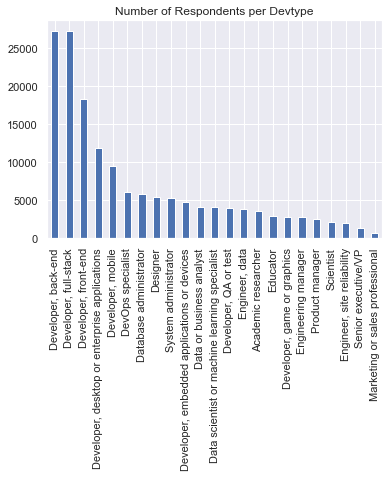

In [80]:
dev_type_totals = devtype_df.sum().sort_values(ascending = False)


from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

pps = dev_type_totals.plot(kind = 'bar', title = 'Number of Respondents per Devtype')


plt.show()

##Decision Makers

Respondent types should inform the model significantly given that they have direct control over the technologies that they use...or at least that is the assumption. There are many instances, especially in large organizations, when only managers have direct decision making power. That is changing, due to the cloud, but decision making still has more significance in the model than direct usage. Nevertheless, this model incorporates both dimensions.

In [87]:
relevant_data_20['PurchaseWhat'].value_counts(dropna = False)

# purchasewhat_totals = purchasewhat.sum().sort_values(ascending = False)
# fig, ax = plt.subplots()

# plt.xticks(rotation=90,wrap=False)

# pps = purchasewhat_totals.plot(kind = 'bar', title = 'Purchase Influence')


# plt.show()

NaN                                 25097
I have little or no influence       16987
I have some influence               15379
I have a great deal of influence     6998
Name: PurchaseWhat, dtype: int64

In [20]:
pd.crosstab(all_devs_df['Hobbyist'], all_devs_df['DevType'])

DevType,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, mobile","Engineer, data",System administrator
Hobbyist,,,,,,,,,,,,,,
No,97,108,9,27,40,93,901,199,117,402,1218,347,49,36
Yes,188,261,30,65,137,192,2185,407,326,999,3206,904,140,124


In [21]:
pd.crosstab(all_devs_df['DevType'], all_devs_df['Employment'])

Employment,Employed full-time,Employed part-time,"Independent contractor, freelancer, or self-employed","Not employed, but looking for work"
DevType,,,,
Data or business analyst,246,9,21,9
Data scientist or machine learning specialist,303,21,19,26
Database administrator,28,3,5,3
Designer,62,8,17,5
DevOps specialist,161,7,8,1
"Developer, QA or test",258,9,9,9
"Developer, back-end",2721,99,163,103
"Developer, desktop or enterprise applications",523,29,43,11
"Developer, embedded applications or devices",394,15,22,12


In [22]:
df = pd.concat([all_devs_df, all_devs_df['DatabaseWorkedWith'].str.split(';', expand=True)], axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  0                       9981 non-null   object
 12  1                       6655 non-null   object
 13  2                       3836 non-null   object
 14  3                       2008 non-null   object
 15  4 

In [24]:
df = df.rename(columns = {0: "CurrentDB0",
                     1: "CurrentDB1",
                     2: "CurrentDB2",
                     3: "CurrentDB3",
                     4: "CurrentDB4", 
                     5:"CurrentDB5",
                     6:"CurrentDB6",
                     7:"CurrentDB7",
                     8:"CurrentDB8",
                     9:"CurrentDB9",
                     10:"CurrentDB10",
                     11:"CurrentDB11",
                     12:"CurrentDB12",
                     13:"CurrentDB13",})

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [26]:
df = pd.concat([df, df['DatabaseDesireNextYear'].str.split(';', expand=True)], axis=1)

In [27]:
df = df.rename(columns = {0: "DesiredDB0",
                     1: "DesiredDB1",
                     2: "DesiredDB2",
                     3: "DesiredDB3",
                     4: "DesiredDB4", 
                     5:"DesiredDB5",
                     6:"DesiredB6",
                     7:"DesiredDB7",
                     8:"DesiredDB8",
                     9:"DesiredDB9",
                     10:"DesiredDB10",
                     11:"DesiredDB11",
                     12:"DesiredDB12",
                     13:"DesiredDB13",})

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [30]:
df = pd.concat([df, df['PlatformDesireNextYear'].str.split(';', expand=True)], axis=1)

In [31]:
df = df.rename(columns = {0: "DesiredPlatform0",
                     1: "DesiredPlatform1",
                     2: "DesiredPlatform2",
                     3: "DesiredPlatform3",
                     4: "DesiredPlatform4", 
                     5:"DesiredPlatform5",
                     6:"DesiredPlatform6",
                     7:"DesiredPlatform7",
                     8:"DesiredPlatform8",
                     9:"DesiredPlatform9",
                     10:"DesiredPlatform10",
                     11:"DesiredPlatform11",
                     12:"DesiredPlatform12",
                     13:"DesiredPlatform13",
                    14:"DesiredPlatform14",
                     15:"DesiredPlatform15",                                 
                                                           })

In [32]:
df = pd.concat([df, df['PlatformWorkedWith'].str.split(';', expand=True)], axis=1)

In [33]:
df = df.rename(columns = {0: "CurrentPlatform0",
                     1: "CurrentPlatform1",
                     2: "CurrentPlatform2",
                     3: "CurrentPlatform3",
                     4: "CurrentPlatform4", 
                     5:"CurrentPlatform5",
                     6:"CurrentPlatform6",
                     7:"CurrentPlatform7",
                     8:"CurrentPlatform8",
                     9:"CurrentPlatform9",
                     10:"CurrentPlatform10",
                     11:"CurrentPlatform11",
                     12:"CurrentPlatform12",
                     13:"CurrentPlatform13",
                    14:"CurrentPlatform14",
                     15:"CurrentPlatform15",                                 
                                                           })

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              12807 non-null  int64 
 1   Country                 12807 non-null  object
 2   Age1stCode              12717 non-null  object
 3   UndergradMajor          11834 non-null  object
 4   Hobbyist                12807 non-null  object
 5   Employment              12807 non-null  object
 6   DevType                 12807 non-null  object
 7   DatabaseDesireNextYear  8716 non-null   object
 8   DatabaseWorkedWith      9981 non-null   object
 9   PlatformDesireNextYear  10131 non-null  object
 10  PlatformWorkedWith      10881 non-null  object
 11  CurrentDB0              9981 non-null   object
 12  CurrentDB1              6655 non-null   object
 13  CurrentDB2              3836 non-null   object
 14  CurrentDB3              2008 non-null   object
 15  Cu

In [35]:
df_toy = df[['Country','DevType','CurrentDB0', 'DesiredDB0', 'DesiredPlatform0', 'CurrentPlatform0']]

In [36]:
df_toy.head()

,Country,DevType,CurrentDB0,DesiredDB0,DesiredPlatform0,CurrentPlatform0
8,Tunisia,"Developer, full-stack",NaN,NaN,NaN,WordPress
16,United States,"Developer, full-stack",Microsoft SQL Server,Cassandra,Docker,NaN
17,United States,"Developer, back-end",Elasticsearch,Elasticsearch,Linux,AWS
18,United States,"Developer, full-stack",MariaDB,MariaDB,iOS,Windows
19,Spain,"Developer, desktop or enterprise applications",IBM DB2,NaN,NaN,Heroku


In [37]:
def count_db(df_toy, column_string,db_name):
    '''Count the number of current or desired databases'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == db_name:
            counter += 1
    return counter

In [38]:
Cur_MySQL = count_db(df_toy, "CurrentDB0","MySQL")
Cur_PostgreSQL = count_db(df_toy, "CurrentDB0","PostgreSQL")
Cur_Microsoft_SQL_Server = count_db(df_toy, "CurrentDB0","Microsoft SQL Server")
Cur_SQLite = count_db(df_toy, "CurrentDB0","SQLite")
Cur_MongoDB = count_db(df_toy, "CurrentDB0","MongoDB")
Cur_Redis = count_db(df_toy, "CurrentDB0","Redis")
Cur_MariaDB = count_db(df_toy, "CurrentDB0","MariaDB")
Cur_Oracle = count_db(df_toy, "CurrentDB0","Oracle")
Cur_Firebase = count_db(df_toy, "CurrentDB0","Firebase")
Cur_Elasticsearch = count_db(df_toy, "CurrentDB0","Elasticsearch")
Cur_DynamoDB = count_db(df_toy, "CurrentDB0","DynamoDB")
Cur_Cassandra = count_db(df_toy, "CurrentDB0","Cassandra")
Cur_IBM_DB2 = count_db(df_toy, "CurrentDB0","IBM DB2")
Cur_Couchbase= count_db(df_toy, "CurrentDB0","Couchbase")

Current_DBs = [
Cur_MySQL,
Cur_PostgreSQL,
Cur_Microsoft_SQL_Server,
Cur_SQLite,
Cur_MongoDB,
Cur_Redis,
Cur_MariaDB,
Cur_Oracle,
Cur_Firebase,
Cur_Elasticsearch,
Cur_DynamoDB,
Cur_Cassandra,
Cur_IBM_DB2,
Cur_Couchbase
]

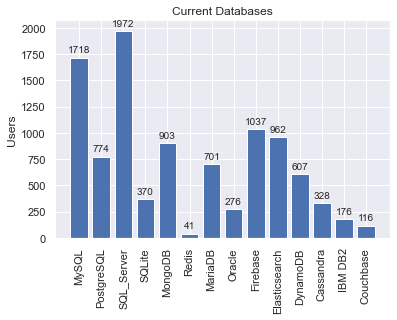

In [39]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Databases')

# ax.bar(x - width/2, Current_DBs, width, label='Current_DBs')

pps = plt.bar(labels,Current_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [40]:
Des_MySQL = count_db(df_toy, "DesiredDB0","MySQL")
Des_PostgreSQL = count_db(df_toy, "DesiredDB0","PostgreSQL")
Des_Microsoft_SQL_Server = count_db(df_toy, "DesiredDB0","Microsoft SQL Server")
Des_SQLite = count_db(df_toy, "DesiredDB0","SQLite")
Des_MongoDB = count_db(df_toy, "DesiredDB0","MongoDB")
Des_Redis = count_db(df_toy, "DesiredDB0","Redis")
Des_MariaDB = count_db(df_toy, "DesiredDB0","MariaDB")
Des_Oracle = count_db(df_toy, "DesiredDB0","Oracle")
Des_Firebase = count_db(df_toy, "DesiredDB0","Firebase")
Des_Elasticsearch = count_db(df_toy, "DesiredDB0","Elasticsearch")
Des_DynamoDB = count_db(df_toy, "DesiredDB0","DynamoDB")
Des_Cassandra = count_db(df_toy, "DesiredDB0","Cassandra")
Des_IBM_DB2 = count_db(df_toy, "DesiredDB0","IBM DB2")
Des_Couchbase= count_db(df_toy, "DesiredDB0","Couchbase")

Desired_DBs = [
Des_MySQL,
Des_PostgreSQL,
Des_Microsoft_SQL_Server,
Des_SQLite,
Des_MongoDB,
Des_Redis,
Des_MariaDB,
Des_Oracle,
Des_Firebase,
Des_Elasticsearch,
Des_DynamoDB,
Des_Cassandra,
Des_IBM_DB2,
Des_Couchbase
]

sum = 0
for i in Desired_DBs:
    sum += i
print(sum)

8716


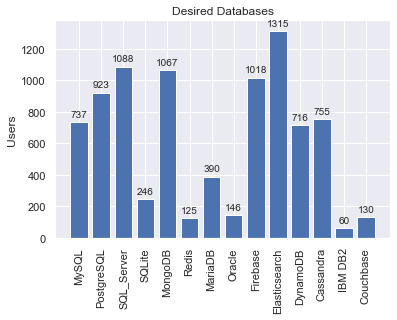

In [41]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Databases')

pps = plt.bar(labels,Desired_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [42]:
def count_platforms(df_toy, column_string,platform_name):
    '''Count the number of desired platforms'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == platform_name:
            counter += 1
    return counter


In [43]:
Linux = count_platforms(df_toy, "DesiredPlatform0","Linux")
Windows = count_platforms(df_toy, "DesiredPlatform0","Windows")
Docker = count_platforms(df_toy, "DesiredPlatform0","Docker")
AWS = count_platforms(df_toy, "DesiredPlatform0","AWS")
Android = count_platforms(df_toy, "DesiredPlatform0","Android")
MacOS = count_platforms(df_toy, "DesiredPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "DesiredPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "DesiredPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "DesiredPlatform0","WordPress")
Google = count_platforms(df_toy, "DesiredPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "DesiredPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "DesiredPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "DesiredPlatform0","Heroku")
Arduino= count_platforms(df_toy, "DesiredPlatform0","Arduino")
Slack = count_platforms(df_toy, "DesiredPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "DesiredPlatform0","IBM Cloud or Watson")

Desired_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Desired_Platforms:
    sum += i
print(sum)


10131


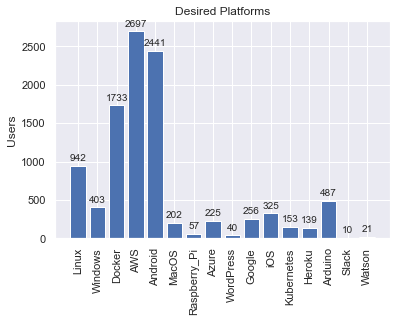

In [44]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Platforms')

pps = plt.bar(labels,Desired_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [45]:
#PlatformWorkedWith0

Linux = count_platforms(df_toy, "CurrentPlatform0","Linux")
Windows = count_platforms(df_toy, "CurrentPlatform0","Windows")
Docker = count_platforms(df_toy, "CurrentPlatform0","Docker")
AWS = count_platforms(df_toy, "CurrentPlatform0","AWS")
Android = count_platforms(df_toy, "CurrentPlatform0","Android")
MacOS = count_platforms(df_toy, "CurrentPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "CurrentPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "CurrentPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "CurrentPlatform0","WordPress")
Google = count_platforms(df_toy, "CurrentPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "CurrentPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "CurrentPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "CurrentPlatform0","Heroku")
Arduino= count_platforms(df_toy, "CurrentPlatform0","Arduino")
Slack = count_platforms(df_toy, "CurrentPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "CurrentPlatform0","IBM Cloud or Watson")

Current_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Current_Platforms:
    sum += i
print(sum)

10881


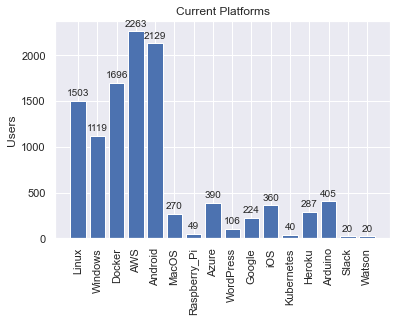

In [46]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Platforms')

pps = plt.bar(labels,Current_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [47]:
#One-hot encoding and training dataset for predicting desired databases

X_database = pd.get_dummies(df_toy, columns= ['DevType','CurrentDB0', 'DesiredPlatform0','CurrentPlatform0'])
X_database = X_database.drop(['Country', 'DesiredDB0'], axis = 1)

In [48]:
#Labels for top desired databases


def desired_database_y(df_toy, column_string, label):
    
    label_name = []
    for i in df_toy[column_string]:
        if i == label:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name

MySQL_y = (desired_database_y(df_toy, 'DesiredDB0', "MySQL"))
Elasticsearch_y = (desired_database_y(df_toy, 'DesiredDB0', "Elasticsearch"))
SQL_Server_y = (desired_database_y(df_toy, 'DesiredDB0', "SQL_Server"))
PostgreSQL_y = (desired_database_y(df_toy, 'DesiredDB0', "PostgreSQL"))
Firebase_y = (desired_database_y(df_toy, 'DesiredDB0', "Firebase"))
DynamoDB_y = (desired_database_y(df_toy, 'DesiredDB0', "DynamoDB"))
np.count_nonzero(Elasticsearch_y)

1315

In [49]:
#Choose a Desired platform to test


# y_label = Azure_y
        
# X_train, X_test, y_train, y_test = train_test_split(X,y_label, test_size = .2)
# clf = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits = 5) 
# scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
# print(scores.mean())



#Create function to make it easier to calculate means for accuracy scores for top labels.

def mean_accuracy_scores(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)
    clf = DecisionTreeClassifier()
    cv = StratifiedKFold(n_splits = 10) 
    scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
    return scores.mean()

print(f"MySQL accuracy score: {mean_accuracy_scores(X_database, MySQL_y)}")
print(f"Elastic accuracy score: {mean_accuracy_scores(X_database, Elasticsearch_y)}")
print(f"SQL Server accuracy score: {mean_accuracy_scores(X_database, SQL_Server_y)}")
print(f"PostgresSQL accuracy score: {mean_accuracy_scores(X_database, PostgreSQL_y)}")
print(f"Firebase accuracy score: {mean_accuracy_scores(X_database, Firebase_y)}")
print(f"DynamoDB accuracy score: {mean_accuracy_scores(X_database, DynamoDB_y)}")




MySQL accuracy score: 0.9311864519817072
Elastic accuracy score: 0.8823811928353658
SQL Server accuracy score: 1.0
PostgresSQL accuracy score: 0.9219133003048781
Firebase accuracy score: 0.9253268864329268
DynamoDB accuracy score: 0.9436793064024389


In [50]:
#visualize Decision Tree:

from sklearn import tree

y = Elasticsearch_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = tree.DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)

# fig = plt.figure(figsize=(25,20))
# tree.plot_tree(clf, filled = True, rounded = True)

In [51]:
# Extract Column Names as List in Pandas Dataframe

predictor_names = X_database.columns.tolist()

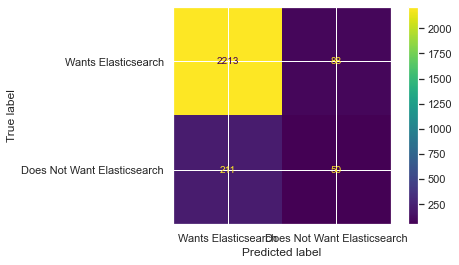

In [52]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels= ["Wants Elasticsearch", "Does Not Want Elasticsearch"])

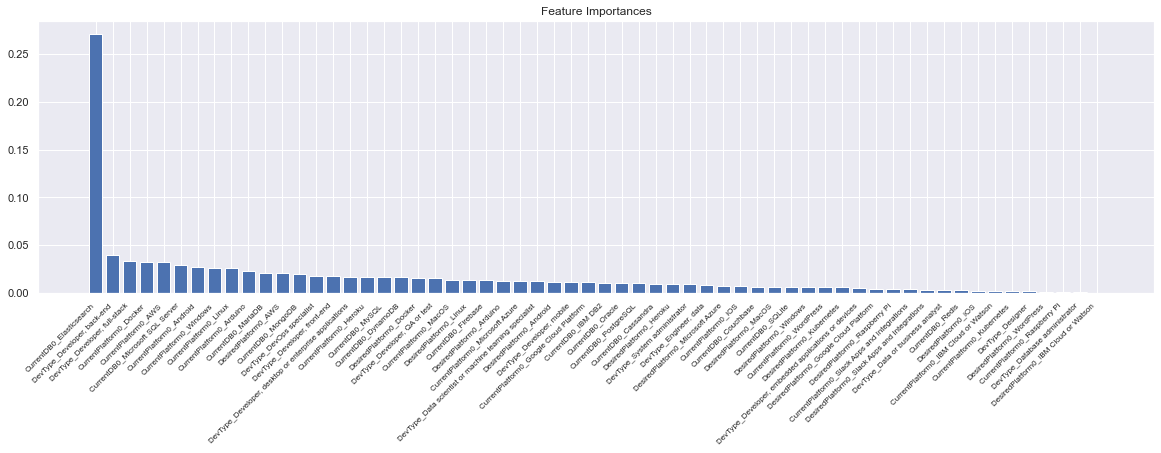

In [53]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

In [54]:
path = clf.cost_complexity_pruning_path(X_train, y_train) # determine values of alpha
ccp_alphas = path.ccp_alphas #extract different values for alpha
cc_alphas = ccp_alphas[:-1] # exclude the max value for alpha

clf_dts = [] #create an array for decision trees

## create one decision tree per value for alpha and store it in the array

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

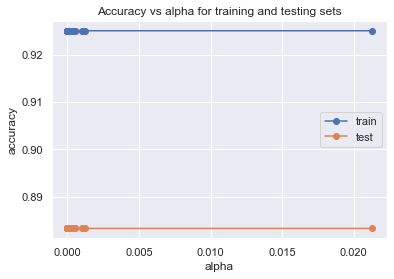

In [55]:
train_scores = [clf.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker = 'o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()